In [11]:
!unzip '/content/data (2) (1).zip'

Archive:  /content/data (2) (1).zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/.DS_Store     
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._.DS_Store  
   creating: data/test/noninvasive/
  inflating: data/test/noninvasive/1637.jpg  
  inflating: data/test/noninvasive/1810.jpg  
  inflating: data/test/noninvasive/1804.jpg  
  inflating: data/test/noninvasive/1838.jpg  
  inflating: data/test/noninvasive/1743.jpg  
  inflating: data/test/noninvasive/1780.jpg  
  inflating: data/test/noninvasive/1794.jpg  
  inflating: data/test/noninvasive/1582.jpg  
  inflating: data/test/noninvasive/1596.jpg  
  inflating: data/test/noninvasive/1597.jpg  
  inflating: data/test/noninvasive/1795.jpg  
  inflating: data/test/noninvasive/1742.jpg  
  inflating: data/test/noninvasive/1839.jpg  
  inflating: data/test/noninvasive/1811.

In [12]:
pip install jcopdl==1.1.9

In [13]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [15]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [17]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur & configuration

In [18]:
from jcopdl.layers import linear_block, conv_block

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(1024, 256, dropout=0.1),  # Dim1 dan Dim2 dari hasil konvolusi terakhir
            linear_block(256, 2, activation="lsoftmax")
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## Training preperation

In [20]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
callback = Callback(model, outdir="model")

## Training

In [21]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7251 | Test_cost  = 0.6931 | Train_score = 0.4960 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6899 | Test_cost  = 0.6643 | Train_score = 0.5300 | Test_score = 0.6825 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6627 | Test_cost  = 0.6404 | Train_score = 0.6130 | Test_score = 0.6900 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6216 | Test_cost  = 0.6038 | Train_score = 0.6750 | Test_score = 0.7100 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.6292 | Test_cost  = 0.6438 | Train_score = 0.6800 | Test_score = 0.7275 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_aliv

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.6065 | Test_cost  = 0.5524 | Train_score = 0.6860 | Test_score = 0.7325 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5567 | Test_cost  = 0.5538 | Train_score = 0.7280 | Test_score = 0.7350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.5325 | Test_cost  = 0.4964 | Train_score = 0.7460 | Test_score = 0.7725 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5303 | Test_cost  = 0.4792 | Train_score = 0.7390 | Test_score = 0.7925 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.5331 | Test_cost  = 0.5069 | Train_score = 0.7190 | Test_score = 0.7750 |
==> EarlyStop patience =  1 | Best test_score: 0.7925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4978 | Test_cost  = 0.5191 | Train_score = 0.7650 | Test_score = 0.7475 |
==> EarlyStop patience =  2 | Best test_score: 0.7925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/pyt

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4856 | Test_cost  = 0.4431 | Train_score = 0.7790 | Test_score = 0.8150 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4658 | Test_cost  = 0.4268 | Train_score = 0.7870 | Test_score = 0.8150 |
==> EarlyStop patience =  1 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4579 | Test_cost  = 0.4067 | Train_score = 0.7880 | Test_score = 0.8225 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4470 | Test_cost  = 0.4141 | Train_score = 0.7940 | Test_score = 0.8200 |
==> EarlyStop patience =  1 | Best test_score: 0.8225


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4248 | Test_cost  = 0.3819 | Train_score = 0.8040 | Test_score = 0.8375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4160 | Test_cost  = 0.3819 | Train_score = 0.8200 | Test_score = 0.8400 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        Exception ignored in: if w.is_alive():if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4a6f853490>


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/l

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.4450 | Test_cost  = 0.3818 | Train_score = 0.7900 | Test_score = 0.8375 |
==> EarlyStop patience =  1 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3975 | Test_cost  = 0.4685 | Train_score = 0.8250 | Test_score = 0.7925 |
==> EarlyStop patience =  2 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.4304 | Test_cost  = 0.3724 | Train_score = 0.7980 | Test_score = 0.8350 |


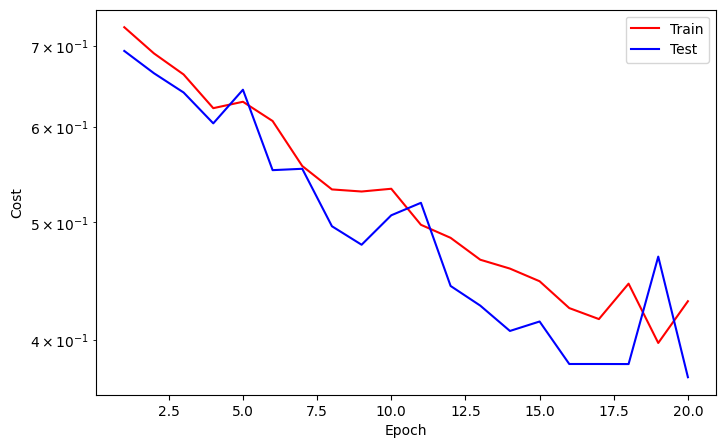

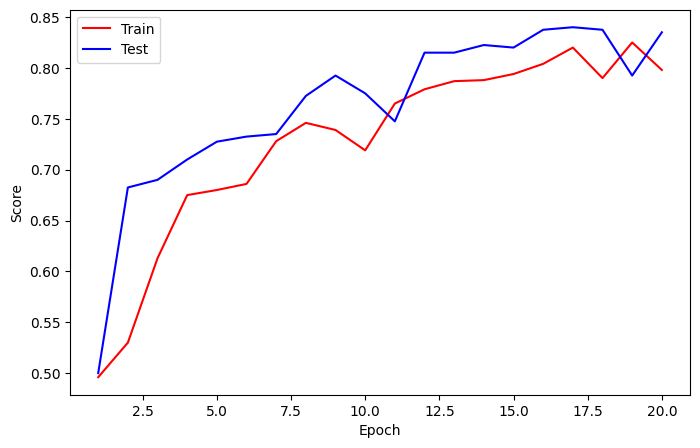

==> EarlyStop patience =  3 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.4108 | Test_cost  = 0.3946 | Train_score = 0.8100 | Test_score = 0.8250 |
==> EarlyStop patience =  4 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.4022 | Test_cost  = 0.3478 | Train_score = 0.8150 | Test_score = 0.8375 |
==> EarlyStop patience =  5 | Best test_score: 0.8400
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8400
==> Best model is saved at model


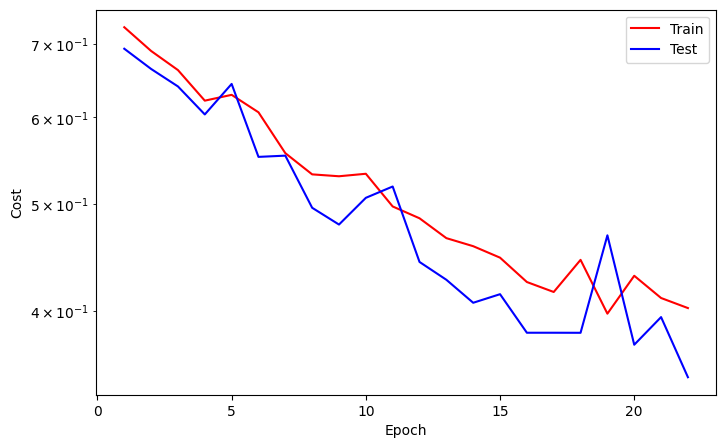

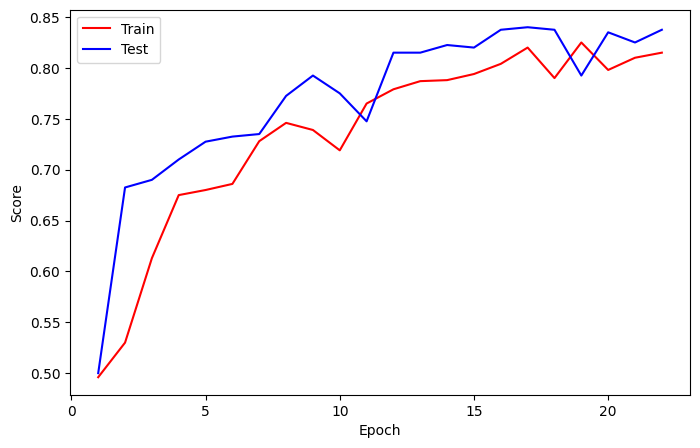

In [22]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Predict

In [23]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [25]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

preds

tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')

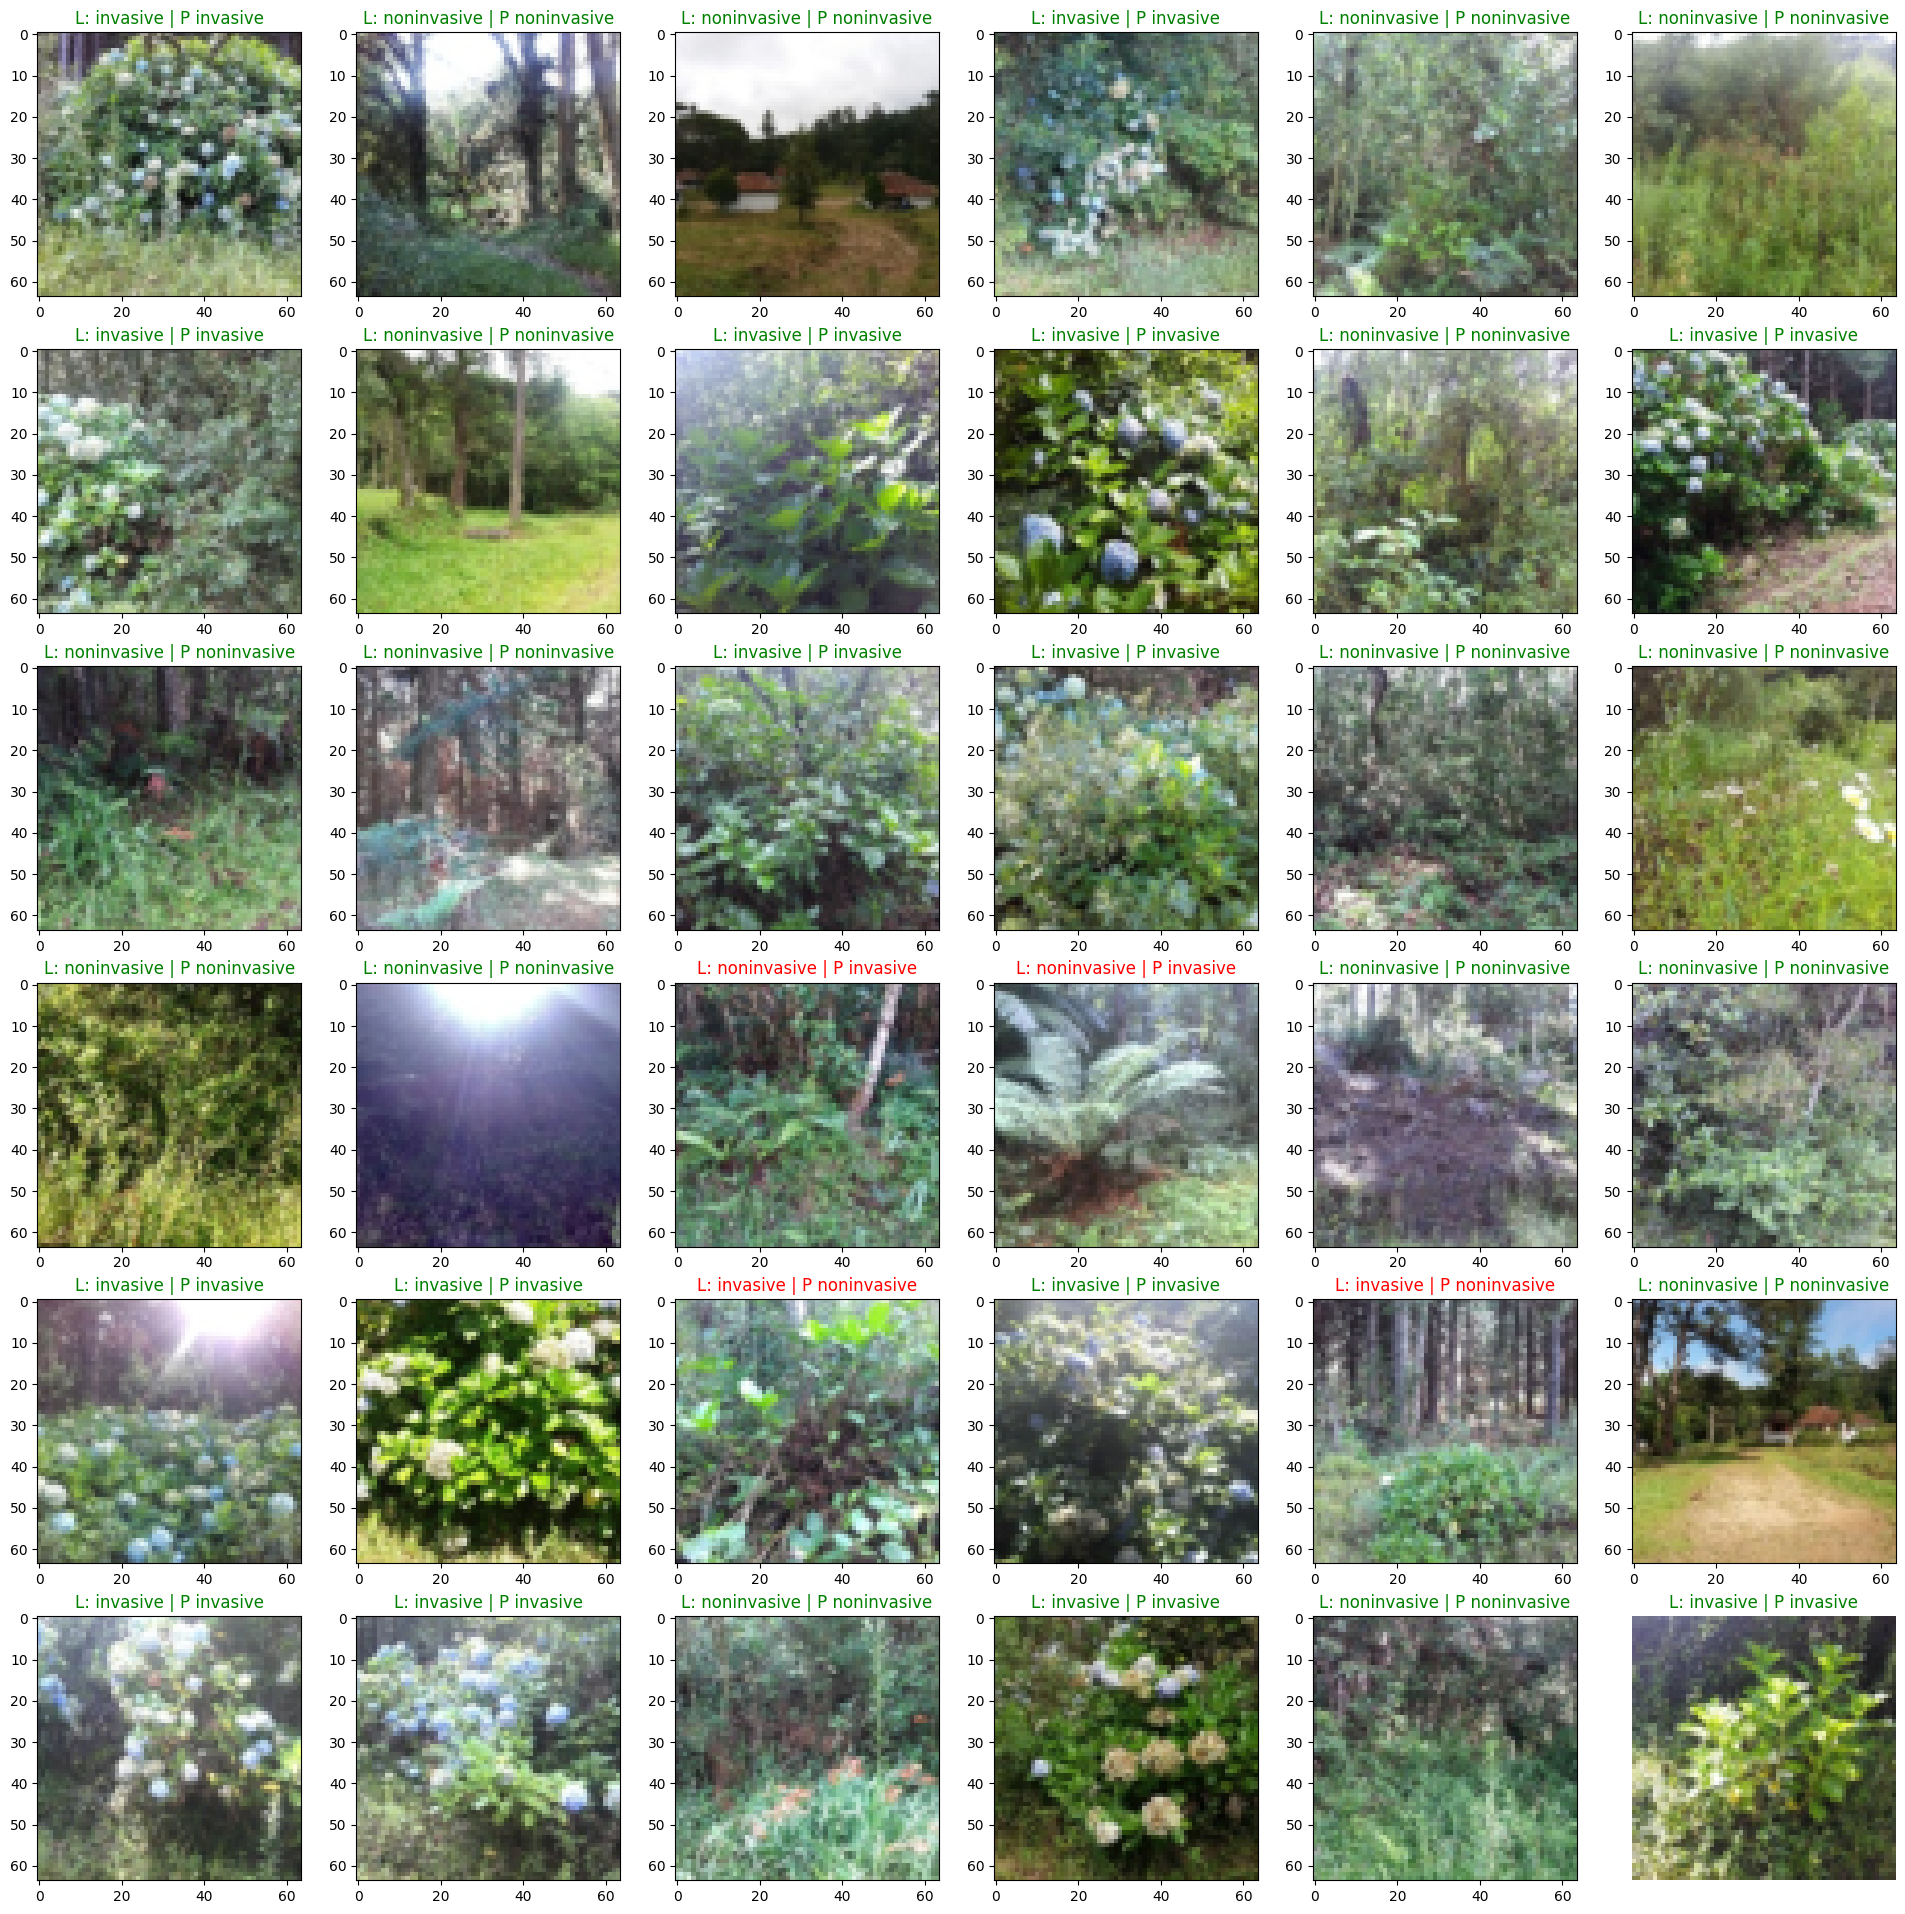

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, ax.flatten()):
    ax.imshow(image.permute(1,2,0).cpu())
    font = {'color':'r'} if label != pred else {'color':'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'L: {label} | P {pred}', fontdict=font)
    plt.axis('off')
